pip install statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error
#import seaborn as sns

# Read the csv file
air_data = pd.read_csv('infilled_data/data_by_measurement_type/air_temperature_data_filled.csv')
wind_data = pd.read_csv('infilled_data/data_by_measurement_type/wind_speed_data_filled.csv')
water_data = pd.read_csv('water_temperatures_data.csv')

# Rename datetime column
air_data.rename(columns={'Unnamed: 0':'Timestamp'}, inplace=True)
wind_data.rename(columns={'Unnamed: 0':'Timestamp'}, inplace=True)
#water_data.rename(columns={'Unnamed: 0':'timestamp'}, inplace=True)

# Convert to dateime, can be probably skipped, did for my own convenience
air_data['Timestamp'] = pd.to_datetime(air_data['Timestamp'],format='%Y-%m-%d')
wind_data['Timestamp'] = pd.to_datetime(wind_data['Timestamp'],format='%Y-%m-%d')
water_data['Timestamp'] = pd.to_datetime(water_data['Timestamp'],format='%Y-%m-%d')

print(air_data.dtypes)

Timestamp                      datetime64[ns]
Alajärvi Möksy                        float64
Asikkala Pulkkilanharju               float64
Eckerö Torp                           float64
Enontekiö Kilpisjärvi Saana           float64
                                    ...      
Virolahti Koivuniemi                  float64
Virrat Äijänneva                      float64
Ylitornio Meltosjärvi                 float64
Ylivieska lentokenttä                 float64
Ähtäri Inha                           float64
Length: 224, dtype: object


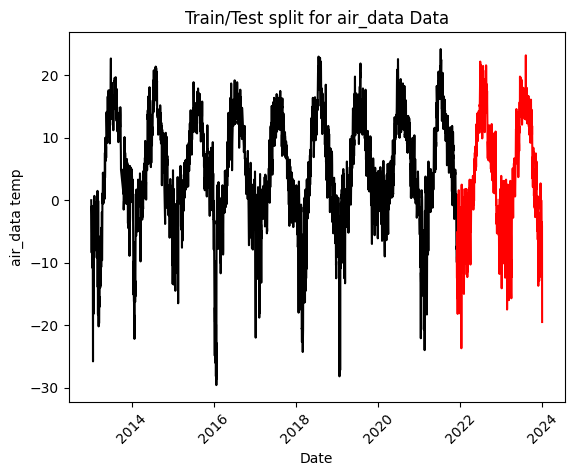

In [37]:
# Splitting all datasets for training, date chosen so its roughly 80% train to 20% test
air_train = air_data[air_data['Timestamp'] < pd.to_datetime("2021-12-01", format='%Y-%m-%d')]
air_test = air_data[air_data['Timestamp'] > pd.to_datetime("2021-12-01", format='%Y-%m-%d')]


# this is a test for one of the stations
plt.plot(air_train['Timestamp'], air_train['Asikkala Pulkkilanharju'],  color = "black")
plt.plot(air_test['Timestamp'], air_test['Asikkala Pulkkilanharju'], color = "red")
plt.ylabel('air_data temp')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for air_data Data")
plt.show()

Now the training process begins with defining model parameters

RMSE:  9.553814294985887


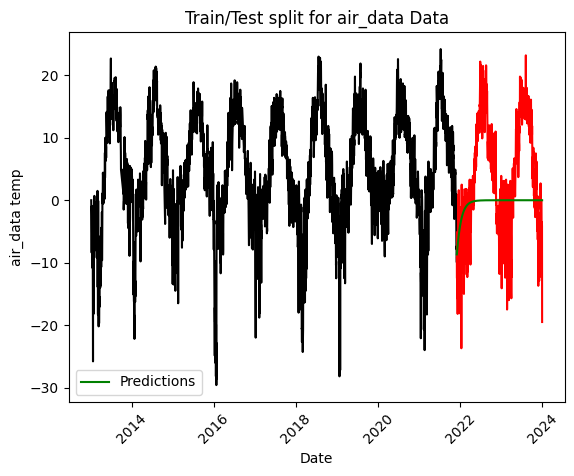

In [40]:
y = air_train['Asikkala Pulkkilanharju']
# ARMAmodel

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()


y_pred = ARMAmodel.get_forecast(len(air_test['Timestamp']))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = air_test['Timestamp']
y_pred_out = y_pred_df["Predictions"] 

arma_rmse = np.sqrt(mean_squared_error(air_test['Asikkala Pulkkilanharju'].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)



plt.plot(air_train['Timestamp'], air_train['Asikkala Pulkkilanharju'],  color = "black")
plt.plot(air_test['Timestamp'], air_test['Asikkala Pulkkilanharju'], color = "red")
plt.ylabel('air_data temp')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for air_data Data")

plt.plot(air_test['Timestamp'], y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

Autoregressive Integrated Moving Average (ARIMA)

c:\Users\roger\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\roger\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Timestamp
2021-12-02   -19.299363
2021-12-03   -16.450481
2021-12-04   -14.814390
2021-12-05   -13.857628
2021-12-06   -13.281531
                ...    
2023-12-27    -1.767866
2023-12-28    -1.767708
2023-12-29    -1.767550
2023-12-30    -1.767394
2023-12-31    -1.767240
Name: Predictions, Length: 760, dtype: float64


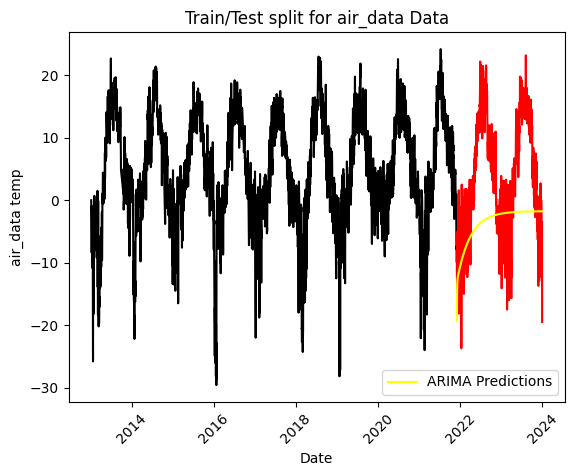

RMSE:  11.112270376373733


In [47]:
from statsmodels.tsa.arima.model import ARIMA
ARIMAmodel = ARIMA(y, order = (2, 0, 2))
ARIMAmodel = ARIMAmodel.fit()
y_pred = ARIMAmodel.get_forecast(len(air_test['Timestamp']))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = air_test['Timestamp']
y_pred_out = y_pred_df["Predictions"] 
print(y_pred_df["Predictions"] )



plt.plot(air_train['Timestamp'], air_train['Asikkala Pulkkilanharju'],  color = "black")
plt.plot(air_test['Timestamp'], air_test['Asikkala Pulkkilanharju'], color = "red")
plt.ylabel('air_data temp')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for air_data Data")

plt.plot(air_test['Timestamp'], y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(air_test['Asikkala Pulkkilanharju'].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

SARIMA


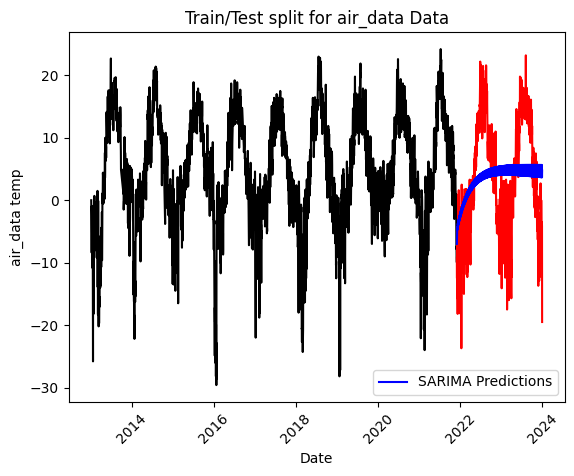

In [22]:
#Ideally, seasonal number should be greater but it takes exponentially longer tiem to train it. 24 already takes 30 mins for one station.
SARIMAXmodel = SARIMAX(y, order = (2, 0, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(air_test['Timestamp']))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = air_test['Timestamp']
y_pred_out = y_pred_df["Predictions"] 


plt.plot(air_train['Timestamp'], air_train['Asikkala Pulkkilanharju'],  color = "black")
plt.plot(air_test['Timestamp'], air_test['Asikkala Pulkkilanharju'], color = "red")
plt.ylabel('air_data temp')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for air_data Data")
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

Zoomed in

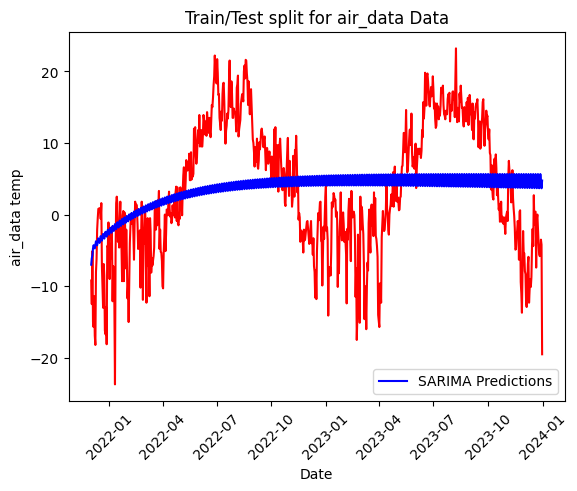

In [23]:
plt.plot(air_test['Timestamp'], air_test['Asikkala Pulkkilanharju'], color = "red")
plt.ylabel('air_data temp')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for air_data Data")
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

I will be using ARIMA for the simplicity and ease of training. 

In [35]:
# EXTRA
air_data_cleaned = air_data.dropna(axis=1, how='any')
wind_data_cleaned = wind_data.dropna(axis=1, how='any')
water_data_cleaned = water_data.dropna(axis=1, how='any')

In [45]:
#y = air_train['Asikkala Pulkkilanharju']
"""
ARIMAmodel = ARIMA(y, order = (2, 0, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(air_test['Timestamp']))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = air_test['Timestamp']
y_pred_out = y_pred_df["Predictions"] 
"""
# Generate new dates:
last_date = air_data['Timestamp'].max()
new_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365*2, freq='D')
new_df = pd.DataFrame({
    'Timestamp': new_dates
})

air_models = []
wind_models = []
water_models = []

column_names = ['Station', 'Prediction']
air_preds = pd.DataFrame(columns=column_names)
wind_preds = pd.DataFrame(columns=column_names)
water_preds = pd.DataFrame(columns=column_names)



In [62]:
#loop through data and get models for each station
import warnings

warnings.filterwarnings('ignore')

air_data_stations = air_data.drop(columns='Timestamp')
for station in air_data_stations:
    y = air_data[station]
    ARIMAmodel = ARIMA(y, order = (2, 0, 2))
    ARIMAmodel = ARIMAmodel.fit()

    y_pred = ARIMAmodel.get_forecast(len(new_df['Timestamp']))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = new_df['Timestamp']
    y_pred_out = y_pred_df["Predictions"]

    new_row = pd.DataFrame([{'Station': station, 'Prediction': y_pred_df["Predictions"].tail(1)[0]}])
    print(new_row)
    air_preds = pd.concat([air_preds, new_row], ignore_index=True)

print(air_preds)


          Station  Prediction
0  Alajärvi Möksy    1.138938
                   Station  Prediction
0  Asikkala Pulkkilanharju     4.23533
       Station  Prediction
0  Eckerö Torp         0.0
                       Station  Prediction
0  Enontekiö Kilpisjärvi Saana   -3.044804
                            Station  Prediction
0  Enontekiö Kilpisjärvi kyläkeskus   -2.390573
             Station  Prediction
0  Enontekiö Näkkälä   -2.767142
                Station  Prediction
0  Enontekiö lentoasema   -2.895908
         Station  Prediction
0  Espoo Nuuksio    3.379898
           Station  Prediction
0  Espoo Sepänkylä    3.396618
         Station  Prediction
0  Espoo Tapiola    4.858128
                  Station  Prediction
0  Haapavesi Mustikkamäki    1.186095
              Station  Prediction
0  Hailuoto Keskikylä    1.606162
               Station  Prediction
0  Hailuoto Marjaniemi    3.090614
         Station  Prediction
0  Halsua Purola    0.832893
             Station  Prediction
0  Ha

In [63]:
#loop through data and get models for each station
import warnings

warnings.filterwarnings('ignore')

wind_data_stations = wind_data.drop(columns='Timestamp')
for station in wind_data_stations:
    y = wind_data[station]
    ARIMAmodel = ARIMA(y, order = (2, 0, 2))
    ARIMAmodel = ARIMAmodel.fit()

    y_pred = ARIMAmodel.get_forecast(len(new_df['Timestamp']))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = new_df['Timestamp']
    y_pred_out = y_pred_df["Predictions"]

    new_row = pd.DataFrame([{'Station': station, 'Prediction': y_pred_df["Predictions"].tail(1)[0]}])
    print(new_row)
    wind_preds = pd.concat([wind_preds, new_row], ignore_index=True)

print(wind_preds)

          Station  Prediction
0  Alajärvi Möksy         0.0
                   Station  Prediction
0  Asikkala Pulkkilanharju    3.123616
       Station  Prediction
0  Eckerö Torp         0.0
                       Station  Prediction
0  Enontekiö Kilpisjärvi Saana    6.567162
                            Station  Prediction
0  Enontekiö Kilpisjärvi kyläkeskus    3.627882
             Station  Prediction
0  Enontekiö Näkkälä    3.217094
                Station  Prediction
0  Enontekiö lentoasema    2.996602
         Station  Prediction
0  Espoo Nuuksio    2.413879
           Station  Prediction
0  Espoo Sepänkylä    2.900659
         Station  Prediction
0  Espoo Tapiola    3.541566
                  Station  Prediction
0  Haapavesi Mustikkamäki         0.0
              Station  Prediction
0  Hailuoto Keskikylä     5.53503
               Station  Prediction
0  Hailuoto Marjaniemi    6.745036
         Station  Prediction
0  Halsua Purola    1.585115
             Station  Prediction
0  Ha

In [64]:
#loop through data and get models for each station
import warnings

warnings.filterwarnings('ignore')

water_data_stations = water_data.drop(columns='Timestamp')
for station in water_data_stations:
    y = water_data[station]
    ARIMAmodel = ARIMA(y, order = (2, 0, 2))
    ARIMAmodel = ARIMAmodel.fit()

    y_pred = ARIMAmodel.get_forecast(len(new_df['Timestamp']))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = new_df['Timestamp']
    y_pred_out = y_pred_df["Predictions"]

    new_row = pd.DataFrame([{'Station': station, 'Prediction': y_pred_df["Predictions"].tail(1)[0]}])
    print(new_row)
    water_preds = pd.concat([water_preds, new_row], ignore_index=True)

print(water_preds)

         Station  Prediction
0  Föglö Degerby    3.008728
               Station  Prediction
0  Hamina Pitäjänsaari    8.989937
                 Station  Prediction
0  Hanko Pikku Kolalahti    6.275913
                Station  Prediction
0  Helsinki Kaivopuisto    7.761681
           Station  Prediction
0  Kaskinen Ådskär    3.203901
     Station  Prediction
0  Kemi Ajos    6.629967
        Station  Prediction
0  Oulu Toppila     5.24079
                  Station  Prediction
0  Pietarsaari Leppäluoto    7.270417
                 Station  Prediction
0  Pori Mäntyluoto Kallo    8.411491
                    Station  Prediction
0  Porvoo Emäsalo Vaarlahti    7.612832
           Station  Prediction
0  Raahe Lapaluoto    6.967584
         Station  Prediction
0  Rauma Petäjäs    6.030093
                      Station  Prediction
0  Turku Ruissalo Saaronniemi    8.147957
            Station  Prediction
0  Vaasa Vaskiluoto    7.319557
                       Station  Prediction
0                

In [ ]:
#Download into csv

air_preds.to_csv('air_preds.csv', index=False)  
wind_preds.to_csv('wind_preds.csv', index=False)  
water_preds.to_csv('water_preds.csv', index=False)  
